# 尋找回歸模型的係數

## 拆分訓練、驗證、測試資料
* 方法一: random 中的 shuffle()
* 方法二: sklearn.model_selection 中的 train_test_split()

In [3]:
#方法一: random 中的 shuffle()
import pandas as pd
import random


def get_train_validation(labeled_df, validation_size=0.3, random_state=123):
    """
    Getting train/validation data from labeled dataframe
    """
    m = labeled_df.shape[0]
    row_indice = list(labeled_df.index)
    random.Random(random_state).shuffle(row_indice)
    shuffled = labeled_df.loc[row_indice, :]
    validation_threshold = int(validation_size * m)
    validation = shuffled.iloc[0:validation_threshold, :]
    train = shuffled.iloc[validation_threshold:, :]
    return train, validation

labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)


train_df, validation_df = get_train_validation(labeled_df)
print(train_df.shape)
print(validation_df.shape)


(1022, 81)
(438, 81)


In [4]:
#方法二: sklearn.model_selection 中的 train_test_split()
import pandas as pd
from sklearn.model_selection import train_test_split

labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
train_df, validation_df = train_test_split(labeled_df, test_size=0.3, random_state=123)
print(train_df.shape)
print(validation_df.shape)

(1022, 81)
(438, 81)


## 相關係數
- .corr()

In [9]:
import pandas as pd

labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
print(labeled_df.head())
df_corr = labeled_df.corr()
print(df_corr.head())

##銷售價格與其他特徵的相關性
sale_price_corr = df_corr["SalePrice"].abs().sort_values(ascending=False)
sale_price_corr[sale_price_corr >= 0.6]

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
Name: SalePrice, dtype: float64

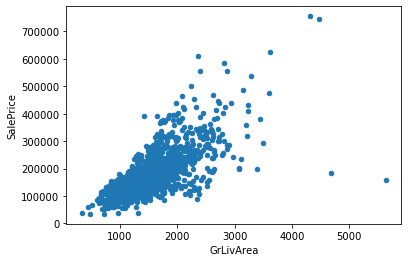

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
labeled_df.plot.scatter("GrLivArea", "SalePrice")
plt.show()

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
train_df, validation_df = train_test_split(labeled_df, test_size=0.3, random_state=123)
print(train_df[["GrLivArea", "SalePrice"]].head(2))
print(train_df[["GrLivArea", "SalePrice"]].tail(2))

     GrLivArea  SalePrice
376        914     148000
250       1306      76500
      GrLivArea  SalePrice
1406        768     133000
1389       1218     131000


## 正規方程

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def get_thetas_lm(X, y):
    m = X.size
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
    ones = np.ones(m, dtype=int).reshape(-1, 1)
    X = np.concatenate([ones, X], axis=1)
    LHS = np.dot(X.T, X)
    RHS = np.dot(X.T, y)
    LHS_inv = np.linalg.inv(LHS)
    thetas = np.dot(LHS_inv, RHS)
    return tuple(thetas.ravel())

labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
train_df, validation_df = train_test_split(labeled_df, test_size=0.3, random_state=123)
X_train = train_df["GrLivArea"].values
y_train = train_df["SalePrice"].values
theta_0, theta_1 = get_thetas_lm(X_train, y_train)
print("Theta 0: {:.4f}".format(theta_0))
print("Theta 1: {:.4f}".format(theta_1))

Theta 0: 21905.1315
Theta 1: 104.0985


## 梯度遞減

Theta 0: 21912.2736
Theta 1: 104.0938


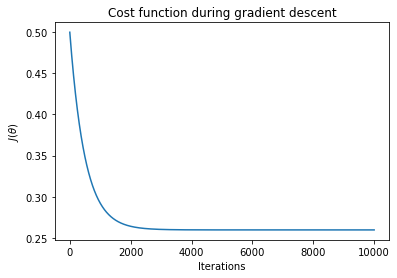

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def compute_cost(X, y, thetas):
    m = X.shape[0]
    h = np.dot(X, thetas)
    J = 1/(2*m)*np.sum(np.square(h - y))
    return J
  
def get_thetas_lm(X, y, alpha=0.001, num_iters=10000):
    thetas = np.array([0, 0]).reshape(-1, 1)
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)
    m = X.shape[0]
    ones = np.ones(m, dtype=int).reshape(-1, 1)
    X = np.concatenate([ones, X], axis=1)
    J_history = np.zeros(num_iters)
    for num_iter in range(num_iters):
        h = np.dot(X, thetas)
        loss = h - y
        gradient = np.dot(X.T, loss)
        thetas = thetas - (alpha * gradient)/m
        J_history[num_iter] = compute_cost(X, y, thetas=thetas)
    return thetas, J_history

def get_rescaled_thetas(thetas, scaler_X, scaler_y, X_train, y_train):
    theta_0 = thetas[0, 0]
    theta_1 = thetas[1, 0]
    scale_X = scaler_X.scale_[0]
    scale_y = scaler_y.scale_[0]
    theta_0_rescaled = y_train.mean() + y_train.std()*theta_0 - theta_1*X_train.mean()*(y_train.std()/X_train.std())
    theta_1_rescaled = theta_1 / scale_X * scale_y
    return theta_0_rescaled, theta_1_rescaled
  
labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
train_df, validation_df = train_test_split(labeled_df, test_size=0.3, random_state=123)
X_train = train_df["GrLivArea"].values.reshape(-1, 1).astype(float)
y_train = train_df["SalePrice"].values.reshape(-1, 1).astype(float)
# Normalization
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
thetas, J_history = get_thetas_lm(X_train_scaled, y_train_scaled)
# Rescaling
theta_0, theta_1 = get_rescaled_thetas(thetas, scaler_X, scaler_y, X_train, y_train)
print("Theta 0: {:.4f}".format(theta_0))
print("Theta 1: {:.4f}".format(theta_1))
# Plotting J_history
plt.plot(J_history)
plt.title("Cost function during gradient descent")
plt.xlabel("Iterations")
plt.ylabel(r"$J(\theta)$")
plt.show()

## 繪製曲面圖

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
  
labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
train_df, validation_df = train_test_split(labeled_df, test_size=0.3, random_state=123)
X_train = train_df["GrLivArea"].values.reshape(-1, 1)
y_train = train_df["SalePrice"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
theta_0 = regressor.intercept_[0]
theta_1 = regressor.coef_[0, 0]
print("Theta 0: {:.4f}".format(theta_0))
print("Theta 1: {:.4f}".format(theta_1))

Theta 0: 21905.1315
Theta 1: 104.0985


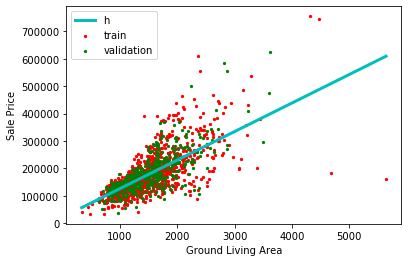

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
  
labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
train_df, validation_df = train_test_split(labeled_df, test_size=0.3, random_state=123)
X_train = train_df["GrLivArea"].values.reshape(-1, 1)
y_train = train_df["SalePrice"].values.reshape(-1, 1)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
theta_0 = regressor.intercept_[0]
theta_1 = regressor.coef_[0, 0]
X_min = labeled_df["GrLivArea"].min()
X_max = labeled_df["GrLivArea"].max()
X_arr = np.linspace(X_min, X_max)
y_hats = theta_0 + theta_1 * X_arr

plt.scatter(train_df["GrLivArea"], train_df["SalePrice"], color="r", s=5, label="train")
plt.scatter(validation_df["GrLivArea"], validation_df["SalePrice"], color="g", s=5, label="validation")
plt.plot(X_arr, y_hats, color="c", linewidth=3, label="h")
plt.legend(loc="upper left")
plt.xlabel("Ground Living Area")
plt.ylabel("Sale Price")
plt.show()

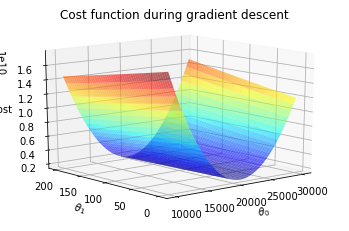

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



def surface_plot(theta0_range, theta1_range, X, y):
    theta0_start, theta0_end = theta0_range
    theta1_start, theta1_end = theta1_range
    length = 50
    theta0_arr = np.linspace(theta0_start, theta0_end, length)
    theta1_arr = np.linspace(theta1_start, theta1_end, length)
    Z = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
            theta_0 = theta0_arr[i]
            theta_1 = theta1_arr[j]
            thetas_arr = np.array([theta_0, theta_1]).reshape(-1, 1)
            Z[i, j] = compute_cost(X, y, thetas=thetas_arr)
    xx, yy = np.meshgrid(theta0_arr, theta1_arr, indexing='xy')

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, Z, rstride=1, cstride=1, alpha=0.6, cmap=plt.cm.jet)
    ax.set_zlabel('Cost')
    ax.set_zlim(Z.min(),Z.max())
    ax.view_init(elev=15, azim=230)
    ax.set_xticks(np.linspace(theta0_start, theta0_end, 5, dtype=int))
    ax.set_yticks(np.linspace(theta1_start, theta1_end, 5, dtype=int))
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_title("Cost function during gradient descent")
    plt.show()
  
labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
train_df, validation_df = train_test_split(labeled_df, test_size=0.3, random_state=123)
X_train = train_df["GrLivArea"].values.reshape(-1, 1).astype(float)
y_train = train_df["SalePrice"].values.reshape(-1, 1).astype(float)
# Surface plot
X_train_reshaped = X_train.reshape(-1, 1)
y_train_reshaped = y_train.reshape(-1, 1)
m = X_train_reshaped.shape[0]
ones = np.ones(m, dtype=int).reshape(-1, 1)
X_train_reshaped = np.concatenate([ones, X_train_reshaped], axis=1)
surface_plot((10000, 30000), (0, 200), X_train_reshaped, y_train_reshaped)

## 繪製動態曲面圖

## 使用模組或套件尋找係數

## 將模型繪製到散佈圖上

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import chart_studio.plotly as py
import plotly.graph_objs as go



def get_surface_Z(theta0_range, theta1_range, X, y):
    theta0_start, theta0_end = theta0_range
    theta1_start, theta1_end = theta1_range
    length = 50
    theta0_arr = np.linspace(theta0_start, theta0_end, length)
    theta1_arr = np.linspace(theta1_start, theta1_end, length)
    Z = np.zeros((length, length))
    for i in range(length):
        for j in range(length):
              theta_0 = theta0_arr[i]
              theta_1 = theta1_arr[j]
              thetas_arr = np.array([theta_0, theta_1]).reshape(-1, 1)
        Z[i, j] = compute_cost(X, y, thetas=thetas_arr)
    return Z
  
labeled_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
labeled_df = pd.read_csv(labeled_url)
train_df, validation_df = train_test_split(labeled_df, test_size=0.3, random_state=123)
X_train = train_df["GrLivArea"].values.reshape(-1, 1).astype(float)
y_train = train_df["SalePrice"].values.reshape(-1, 1).astype(float)
# Normalization
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
thetas, J_history = get_thetas_lm(X_train_scaled, y_train_scaled)
# Rescaling
theta_0, theta_1 = get_rescaled_thetas(thetas, scaler_X, scaler_y, X_train, y_train)
# Surface plot
X_train_reshaped = X_train.reshape(-1, 1)
y_train_reshaped = y_train.reshape(-1, 1)
m = X_train_reshaped.shape[0]
ones = np.ones(m, dtype=int).reshape(-1, 1)
X_train_reshaped = np.concatenate([ones, X_train_reshaped], axis=1)
Z = get_surface_Z((10000, 30000), (0, 200), X_train_reshaped, y_train_reshaped)

py.sign_in('USERNAME', 'APIKEY') # Use your own plotly Username / API Key
data = [go.Surface(z=Z)]
layout = go.Layout(
  title='Cost function during gradient descent',
  scene=dict(
      xaxis = dict(title='theta_0'),
      yaxis = dict(title="theta_1"),
      zaxis = dict(title="J(theta)")
  )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='gd-3d-surface')

PlotlyError: Sign in failed.